# Imports and Setup

In [1]:
import argparse
import glob
import os
import random
import re
import pandas as pd
import numpy as np
import csv
import json
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import collections

from tqdm.auto import tqdm
import pickle

from string2string.alignment import NeedlemanWunsch
from string2string.misc.plotting_functions import plot_pairwise_alignment


%load_ext autoreload
%autoreload 2

In [2]:
# Spacy setup. Need to be done once.
!pip -q install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!pip install plotly
!pip install string2string
## !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.7 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 58.4 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [2]:
import spacy
from spacy.lang.es.examples import sentences 
from spacy import displacy

print(spacy.__version__)
print(pd.__version__)

# from nltk.parse import stanford, corenlp
NLP_ES = spacy.load("es_core_news_sm")
NLP_EN = spacy.load("en_core_web_sm")

3.7.2
1.4.2


In [3]:
from utils import Config
args = Config()

In [4]:
# Helper methods
def add_neighbors_of(idx, cur_order, words, id_to_head, head_to_ids):
    if idx is None:
        # Handle edge case where we do not have an index to work with.
        return
    if cur_order > 3:
        # We are only interesting in the first three orders of dependency:
        #  1 - self
        #  2 - immediate neighbors and 
        #  3 - 1-skip neighbors
        return
    if f'{idx}' in words:
        # Node has been processed already
        return
    if idx not in id_to_head:
        # The current index does not identify a word in the corrected sentence.
        # This can happen as the correction index holds indices into string with both 
        # versions (corrected and uncorrected) appended.
        return

    # Add current index and its order to the dict
    words[f'{idx}'] = cur_order
    
    # Process head of current index
    upstream = id_to_head[idx]
    add_neighbors_of(upstream, cur_order + 1, words, id_to_head, head_to_ids)

    # Process words that are immediately downstream of current index
    if idx in head_to_ids:
        downstream = head_to_ids[idx]
        [add_neighbors_of(down_idx, cur_order + 1, words, id_to_head, head_to_ids) for down_idx in downstream]
    

def dep_parsing_tree(nlp, text, correction_index, verbosity=0):
    if len(correction_index) == 0:
        return dict()
    
    doc = nlp(text)
    js_str = doc.to_json()
    id_to_head = dict()
    head_to_ids = dict()
    for token in js_str["tokens"]:
        id = token["id"]
        head = token["head"]
        if token['pos'] != 'PUNCT':
            id_to_head[id] = head
            if head in head_to_ids:
                head_to_ids[head].append(id)
            else:
                head_to_ids[head] = [id]
    if verbosity > 0:
        print(f'id -> head: {id_to_head}')
        print(f'head -> ids: {head_to_ids}')            
        
    pred_parse_order = dict()
    for cor_idx in correction_index:
        add_neighbors_of(cor_idx, 1, pred_parse_order, id_to_head, head_to_ids)

    pred_parse_order = dict(sorted(pred_parse_order.items()))
    if verbosity > 0:
        df_dep_tree = pd.DataFrame()
        df_dep_tree['text'] = [token.text for token in doc]
        df_dep_tree['lemma'] = [token.lemma_ for token in doc]
        df_dep_tree['is_punctuation'] = [token.is_punct for token in doc]
        df_dep_tree['is_space'] = [token.is_space for token in doc]
        df_dep_tree['shape'] = [token.shape_ for token in doc]
        df_dep_tree['part_of_speech'] = [token.pos_ for token in doc]
        df_dep_tree['pos_tag'] = [token.tag_ for token in doc]
        df_dep_tree['head'] = [token.head.text for token in doc] 
        df_dep_tree['dep'] = [token.dep_ for token in doc]
        html = displacy.render(doc, style="dep")
        HTML(html)
    return pred_parse_order

In [5]:
# Define class id mappers
classes_ids = {
    'article': 's1',
    'gender agreement': 's2',
    'gender and number agreement': 's3',
    'number agreement': 's5'
}

# Load Data and do Sanity Tests

## Sanity on Full Data

In [6]:
def load():
    # Converters not working
    df = pd.read_csv(args.PROCESSED_DATA_FOLDER + "/final.csv", index_col=None, header=0)
    # The source, target and correction_index cols are loaded as string version of lists. Convert them to actual lists.
    df.source = df.apply(lambda row: eval(row.source), axis=1)
    df.target = df.apply(lambda row: eval(row.target), axis=1)
    df.correction_index = df.apply(lambda row: eval(row.correction_index), axis=1)
    
    df['evidence_index'] = np.empty((len(df), 0)).tolist()
    df['predicted_parsing_order'] = ""
    df['origin'] = 'A'
    return df

df_raw = load()

In [7]:
# Check the columns
df_raw.columns

Index(['Unnamed: 0', 'paragraph_id', 'sentence_id', 'course', 'essay_new',
       'annotated_sentence', 'anno_error_cnt', 'full_error_tag', 'order_tag',
       'error_tag', 'correction', 'error', 'target', 'correction_index',
       'error_type', 'source', 'new_error_type', 'evidence_index',
       'predicted_parsing_order', 'origin'],
      dtype='object')

In [8]:
# All rows should have an error_type
df_raw[df_raw.error_type.isnull()]

,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,error_tag,correction,error,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin


In [9]:
# Check for null values
df_raw[df_raw.notnull()].count()

Unnamed: 0                 5223
paragraph_id               5223
sentence_id                5223
course                     5223
essay_new                  5223
annotated_sentence         5223
anno_error_cnt             5223
full_error_tag             5223
order_tag                  5223
error_tag                  5223
correction                 5174
error                      4809
target                     5223
correction_index           5223
error_type                 5223
source                     5223
new_error_type             5223
evidence_index             5223
predicted_parsing_order    5223
origin                     5223
dtype: int64

In [10]:
df_raw.isna().sum()

Unnamed: 0                   0
paragraph_id                 0
sentence_id                  0
course                       0
essay_new                    0
annotated_sentence           0
anno_error_cnt               0
full_error_tag               0
order_tag                    0
error_tag                    0
correction                  49
error                      414
target                       0
correction_index             0
error_type                   0
source                       0
new_error_type               0
evidence_index               0
predicted_parsing_order      0
origin                       0
dtype: int64

In [11]:
# with pd.option_context('display.max_colwidth', None):
#     print(df_raw[['source', 'target']].sample(n=50))


## Split Dataset into With Errors and Without Errors

In [16]:
# Split dataset into two dataframes one with errors and one without
def split_on_error(df):
    df_no_errors = df.query('error_type == "None"').copy()
    df_no_errors.reset_index(inplace=True)
    df_no_errors.rename(columns={'index': "orig_index"}, inplace=True)
    df_errors = df.query('error_type != "None"').copy()
    df_errors['orig_error_type'] = df_errors['error_type']
    df_errors['error_type'] = df_errors['new_error_type']

    df_errors.reset_index(inplace=True)
    df_errors.rename(columns={'index': "orig_index"}, inplace=True)
    return df_errors, df_no_errors

df_errors, df_no_errors = split_on_error(df_raw)

In [17]:
# df_errors.to_csv(args.PROCESSED_DATA_FOLDER + "/final_with_errors.csv", index=False)

In [18]:
df_errors.index[(df_errors.essay_new == 'Entonces será certificado como “perfecto".')]

Int64Index([5221, 5222], dtype='int64')

In [19]:
df_errors[df_errors.notnull()].count()

orig_index                 5223
Unnamed: 0                 5223
paragraph_id               5223
sentence_id                5223
course                     5223
essay_new                  5223
annotated_sentence         5223
anno_error_cnt             5223
full_error_tag             5223
order_tag                  5223
error_tag                  5223
correction                 5174
error                      4809
target                     5223
correction_index           5223
error_type                 5223
source                     5223
new_error_type             5223
evidence_index             5223
predicted_parsing_order    5223
origin                     5223
orig_error_type            5223
dtype: int64

In [20]:
df_no_errors[df_no_errors.notnull()].count()

orig_index                 0
Unnamed: 0                 0
paragraph_id               0
sentence_id                0
course                     0
essay_new                  0
annotated_sentence         0
anno_error_cnt             0
full_error_tag             0
order_tag                  0
error_tag                  0
correction                 0
error                      0
target                     0
correction_index           0
error_type                 0
source                     0
new_error_type             0
evidence_index             0
predicted_parsing_order    0
origin                     0
dtype: int64

In [21]:
df_errors.full_error_tag.unique()

array(['[]{a}<az:do:an>', '[a]{}<za:do:inan>', '[al]{al}<aa:do:an>', ...,
       '[fresco]{frescos}<na:ps:adj:inan>',
       '[encurtido]{encurtidos}<na:ps:adj:inan>',
       '[certificado]{certificadas}<ga:fm:adj:inan>'], dtype=object)

In [22]:
df_errors.error_type.unique()

array(['article', 'number agreement', 'gender agreement',
       'gender and number agreement'], dtype=object)

In [23]:
# # Reduce the number of error classes to 4 - ga, na, ga-na and az.
# error_map = {
# 'aa:do': 'az',
# 'az:do': 'az',
# 'za:do': 'az',
# 'aa:io': 'az',
# 'az:io': 'az',
# 'na:ps': 'na',
# 'ga:fm': 'ga',
# 'ga:mf:det:aty': 'ga',
# 'ga:mf': 'ga',
# 'ig:f': 'na',
# 'na:sp': 'na',
# 'in:s': 'na',
# 'ga:na:fm:ps': 'ga-na',
# 'ga:fm:det:aty': 'ga',
# 'ga:ps': 'ga',
# 'ig:e': 'na',
# 'ig:m': 'na',
# 'ga:na:mf:ps': 'ga-na',
# 'ga:mf:noun:aty': 'ga',
# 'ga:mf:adj:aty': 'ga',
# 'ga:na:fm:sp': 'ga-na',
# 'ga:na:mf:sp': 'ga-na',
# 'in:p': 'na',
# 'ga:fm:adj:aty': 'ga',
# 'ga:fm:noun:aty': 'ga',
# 'ig:in:f:s': 'na',
# 'ga:fm:gat:noun': 'ga',
# 'in:p:gat:noun': 'na',
# 'na:sp:gat:noun': 'na',
# 'ga:mf:pron:aty': 'ga',
# 'in:s:gat:noun': 'na',
# 'ga': 'ga'}

# df_errors['error_type'] = df_errors.apply(lambda row: error_map[row.orig_error_type], axis=1)

In [24]:
df_errors.error_type.value_counts()

gender agreement               2995
number agreement               1460
article                         477
gender and number agreement     291
Name: error_type, dtype: int64

## Fix Data Issues

### Handle Non-breaking Space Character

In [25]:
# Some of the sentences have non-breaking space ('\xa0') which breaks dependency tree logic.
# Count number of lines with non-breaking space in them
def cleanup_nbsp(df):
    rows_with_nbsp = df[(df.essay_new.str.contains('\xa0'))]
    print(f"{rows_with_nbsp.shape[0]} rows have non-breaking spaces before cleanup.")
    df.essay_new = df.essay_new.str.replace('\xa0', ' ')
    rows_with_nbsp = df[(df.essay_new.str.contains('\xa0'))]
    print(f"{rows_with_nbsp.shape[0]} rows have non-breaking spaces after cleanup.")
    return df

df_errors = cleanup_nbsp(df_errors)

273 rows have non-breaking spaces before cleanup.
0 rows have non-breaking spaces after cleanup.


### Handle Newline Characters

In [26]:
# Some of the sentences have new line characters which breaks dependency tree logic.
def cleanup_new_line(df):
    rows = df[(df.essay_new.str.contains(r'\n+'))]
    print(f"{rows.shape[0]} rows have new line before cleanup.")
    sampled = None
    if rows.shape[0] > 0:
        sampled = rows.sample(10).index
        print(f'Few samples before cleanup:')
        print(df.iloc[sampled].essay_new)
    df.essay_new = df.essay_new.str.replace('\n', ' ')
    if sampled is not None:
        print(f'\nSame entries after cleanup:')
        print(df.iloc[sampled].essay_new)

    rows = df[(df.essay_new.str.contains('\n'))]
    print(f"{rows.shape[0]} rows have double spaces after cleanup.")
    return df

df_errors, df_no_errors = split_on_error(df_raw)
df_errors = cleanup_new_line(df_errors)

72 rows have new line before cleanup.
Few samples before cleanup:
3988                    \n\nOtro persona famoso es Oprah.
568     \n\nYo vi Selena primera en Wizard of Waverly ...
1845    \n\nSi viajaría a Norway, yo visitara mi famil...
950     \nMi atleta favorita es Rob Gronkowski, un jug...
1806    \n\nEl próxima día, vamos a comer el desayuno ...
1848    \n\nTraería mucho dinero para comprar la ropa ...
438     \n\nEn el serie de televisión The Good Place, ...
4971    \n\nEn el ultimo día mis novia y yo tendríamos...
4149    Mi vacacione perfecto\nSi fuera a una vacación...
4851     \n\nEste es mi vacación perfecto - \n\nEl pri...
Name: essay_new, dtype: object

Same entries after cleanup:
3988                        Otro persona famoso es Oprah.
568       Yo vi Selena primera en Wizard of Waverly Pl...
1845      Si viajaría a Norway, yo visitara mi familia...
950      Mi atleta favorita es Rob Gronkowski, un juga...
1806      El próxima día, vamos a comer el desayuno ta...
1848

### Handle Double Space Characters

In [27]:
# Some of the sentences have multiple spaces which breaks dependency tree logic.
# Count number of lines with multiple spaces in them
def cleanup_double_spaces(df):
    rows = df[(df.essay_new.str.contains(r'\s\s+'))]
    print(f"{rows.shape[0]} rows have double spaces before cleanup.")
    sampled = None
    if rows.shape[0] > 0:
        sampled = rows.sample(10).index
        print(f'Few samples before cleanup:')
        print(df.iloc[sampled].essay_new)
    # df.essay_new = df.essay_new.str.replace('  ', ' ')

    df.essay_new = df.essay_new.str.replace(r'\s+', ' ', regex=True).str.strip()
    if sampled is not None:
        print(f'\nSame entries after cleanup:')
        print(df.iloc[sampled].essay_new)

    print(f"{df[(df.essay_new.str.contains('  '))].shape[0]} rows have double spaces after cleanup.")
    return df

# df_errors, df_no_errors = split_on_error(df_raw)
df_errors = cleanup_double_spaces(df_errors)

139 rows have double spaces before cleanup.
Few samples before cleanup:
4209      Por la próxima cuatro días, vamos a pasar ti...
4210      Por la próxima cuatro días, vamos a pasar ti...
369     Yo quiero cantar y bailar en la  playa y conoz...
3988                        Otro persona famoso es Oprah.
1845      Si viajaría a Norway, yo visitara mi familia...
2164    En algunos días nosotros iríamos a los museos ...
4757                Eses días son difícil porque la vi...
2825          Nosotros nos quedamos en los Estados Uni...
1754      Para tener una perfecta vacación, voy a tene...
4360    Yo quiere que  nosotros  vayamos a la playas y...
Name: essay_new, dtype: object

Same entries after cleanup:
4209    Por la próxima cuatro días, vamos a pasar tiem...
4210    Por la próxima cuatro días, vamos a pasar tiem...
369     Yo quiero cantar y bailar en la playa y conozc...
3988                        Otro persona famoso es Oprah.
1845    Si viajaría a Norway, yo visitara mi familia y..

In [28]:
df_errors.iloc[[1078, 1472]].essay_new

1078                      Ella también es actor.
1472    Demi no tiene novio porque está ocupado.
Name: essay_new, dtype: object

### Sanity Check Lines with Errors

In [29]:
def compute_status(row):
    num_len_mismatch = 0
    num_extra_corrections = 0
    source = row.source
    target = row.target
    correction_index = set(row.correction_index)
    row_status = 'GOOD'
    if len(source) != len(target):
        num_len_mismatch = num_len_mismatch + 1
        row_status = 'LEN_MISMATCH'
    else:
        mismatches = map(lambda x: x[0] == x[1], zip(source, target))
        for (i, flag) in enumerate(mismatches):
            if not flag and i not in correction_index:
                # print('Extra corrections')
                num_extra_corrections = num_extra_corrections + 1
                row_status = 'EXTRA_CORRECTIONS'
                break
    return row_status

def check_errors():
    df_status = df_errors[['orig_index', 'sentence_id', 'essay_new', 'source', 'target', 'correction_index']].copy(deep=True)
    df_status['status'] = df_status.apply(compute_status, axis=1)
    df_status['has_annotation'] = df_status.apply(lambda row: '<' in row.source or '<' in row.target, axis=1)
    return df_status
    
df_error_status = check_errors()

In [30]:
print('Should have just GOOD rows')
print(df_error_status.status.value_counts())

print()
print('Should not have annotations')
print(df_error_status.has_annotation.value_counts())

with pd.option_context('display.max_colwidth', None):
    display(df_error_status[df_error_status['status'] == 'EXTRA_CORRECTIONS'])
    print("----------------------")
    display(df_error_status[df_error_status.has_annotation == True])

Should have just GOOD rows
GOOD    5223
Name: status, dtype: int64

Should not have annotations
False    5223
Name: has_annotation, dtype: int64


,orig_index,sentence_id,essay_new,source,target,correction_index,status,has_annotation


----------------------


,orig_index,sentence_id,essay_new,source,target,correction_index,status,has_annotation


In [31]:
# Check on alignment logic to ensure that all lines in the error dataset can be aligned
def is_same(list1, list2):
    if len(list1) != len(list2):
        return False
    
    for v1, v2 in zip(list1, list2):
        if v1.strip() != v2.strip():
            return False
        
    return True
        
def print_context(row):
    print(f'error_type: {row.error_type} => {row.new_error_type}')

def alignment_sanity(df, context_printer=None, verbosity=0):
    mismatches = 0
    for i, row in df.iterrows():
        nw = NeedlemanWunsch()
        aligned_s1, aligned_s2, score_matrix = nw.get_alignment(row.source, row.target, return_score_matrix=True)
        path, s1_pieces, s2_pieces = nw.get_alignment_strings_and_indices(aligned_s1, aligned_s2)
        if not (is_same(row.source, s1_pieces) and is_same(row.target, s2_pieces)):
            mismatches = mismatches + 1
            if verbosity > 0:
                print('----------------------------------------------')
                if context_printer:
                    context_printer(row)
                print(f"Original: \n=>{row.source}\n=>{row.target}")
                print(f'Correction index: {row.correction_index}')
                print(f'Path:\n{path}\n===>{s1_pieces}, \n===>{s2_pieces}')

    print('----------------------------------------------')
    return mismatches

print(f'Lower number of mismatches is better with 0 being ideal')
print(f"Number of mismatches in COWS-L2H dataset: {alignment_sanity(df_errors)}/{df_errors.shape[0]}")


Lower number of mismatches is better with 0 being ideal
----------------------------------------------
Number of mismatches in COWS-L2H dataset: 0/5223


In [32]:
print(f'Distribution of number of elements in correction count')
print(df_errors.correction_index.map(lambda v: len(v)).value_counts())
print('')
print(f'Pretty much every row has 2 indices for correction count which means none of the sentences have more than one word changing. Alignment is easier.')


Distribution of number of elements in correction count
2    5223
Name: correction_index, dtype: int64

Pretty much every row has 2 indices for correction count which means none of the sentences have more than one word changing. Alignment is easier.


# Explore EXPECT dataset

In [30]:
def load_expect_data(num_lines=None):
    expect_train_file = f"{args.EXPLAINABLE_GEC_DATA_FOLDER}/train.json"
    with open(expect_train_file, "r") as file1:
        count = 0
        rows = file1.readlines()
        df = pd.DataFrame([eval(row) for row in rows])
        df['source_org'] = df.source.map(lambda v: ' '.join(v).replace(" .", "."))        
        df['target_org'] = df.target.map(lambda v: ' '.join(v).replace(" .", "."))
        return df

df_expect = load_expect_data()


In [31]:
with pd.option_context('display.max_colwidth', None):
    display(df_expect.sample(5))

,target,source,evidence_index,correction_index,error_type,predicted_parsing_order,origin,source_org,target_org
4992,"[Apart, from, that, ,, even, greater, is, the, pollution, of, the, seas, and, rivers, .]","[Apart, from, that, ,, even, greater, is, the, pollution, of, [NONE], seas, and, rivers, .]","[11, 12, 13, 27, 28, 29]","[10, 26]",Article,"{'6': 3, '8': 2, '10': 1, '22': 3, '24': 2, '26': 1}",A,"Apart from that , even greater is the pollution of [NONE] seas and rivers.","Apart from that , even greater is the pollution of the seas and rivers."
418,"[First, ,, as, everybody, knows, ,, the, cost, of, fuel, is, increasing, more, and, more, ., Adding, to, that, the, bills, that, owning, a, car, will, bring, ,, it, becomes, immediately, clear, that, it, is, cheaper, to, get, around, by, public, transport, .]","[First, ,, as, everybody, knows, ,, the, cost, of, fuel, is, increasing, more, and, more, ., Adding, to, those, the, bills, that, owning, a, car, will, bring, ,, it, becomes, immediately, clear, that, it, is, cheaper, to, get, around, by, public, transport, .]","[6, 7, 8, 9, 50, 51, 52, 53]","[18, 62]",Pronoun-Antecedent Agreement,"{'17': 3, '18': 1, '30': 2, '61': 3, '62': 1, '74': 2}",A,"First , as everybody knows , the cost of fuel is increasing more and more. Adding to those the bills that owning a car will bring , it becomes immediately clear that it is cheaper to get around by public transport.","First , as everybody knows , the cost of fuel is increasing more and more. Adding to that the bills that owning a car will bring , it becomes immediately clear that it is cheaper to get around by public transport."
7487,"[I, hope, one, day, all, children, will, rely, on, their, parents, as, their, teachers, .]","[I, hope, one, day, all, children, [NONE], rely, on, their, parents, as, their, teachers, .]","[2, 3, 18, 19]","[6, 22]",Verb Tense,"{'1': 3, '6': 1, '7': 2, '17': 3, '22': 1, '23': 2}",B,I hope one day all children [NONE] rely on their parents as their teachers.,I hope one day all children will rely on their parents as their teachers.
15062,"[Before, 2014, ,, Trivago, was, not, famous, in, Asia, .]","[Before, 2014, ,, Trivago, is, not, famous, in, Asia, .]","[0, 1, 11, 12]","[4, 15]",Verb Tense,"{'4': 1, '6': 2, '15': 1, '17': 2}",C,"Before 2014 , Trivago is not famous in Asia.","Before 2014 , Trivago was not famous in Asia."
12489,"[Thanks, to, learning, another, language, ,, you, can, also, have, friends, from, all, over, the, world, and, you, can, better, understand, the, culture, of, a, new, country, .]","[Thanks, to, learning, another, language, ,, you, can, also, have, friends, from, all, [NONE], the, world, and, you, can, better, understand, the, culture, of, a, new, country, .]","[11, 12, 14, 15, 40, 41, 43, 44]","[13, 42]",Preposition,"{'10': 2, '12': 2, '13': 1, '14': 3, '15': 2, '39': 2, '41': 2, '42': 1, '43': 3, '44': 2}",B,"Thanks to learning another language , you can also have friends from all [NONE] the world and you can better understand the culture of a new country.","Thanks to learning another language , you can also have friends from all over the world and you can better understand the culture of a new country."


In [32]:
df_expect.isna().sum()

target                     0
source                     0
evidence_index             0
correction_index           0
error_type                 0
predicted_parsing_order    0
origin                     0
source_org                 0
target_org                 0
dtype: int64

## Dependency parsing tree on EXPECT

In [33]:
with pd.option_context('display.max_colwidth', None):
    display(df_expect.iloc[11872])

target                                 [The, periodic, movement, of, the, minute, hand, compared, to, the, smooth, path, of, the, second, hand, .]
source                                     [The, periodic, move, of, the, minute, hand, compared, to, the, smooth, path, of, the, second, hand, .]
evidence_index                                                                                                                      [0, 1, 18, 19]
correction_index                                                                                                                           [2, 20]
error_type                                                                                                                           POS Confusion
predicted_parsing_order    {'0': 2, '1': 2, '2': 1, '3': 2, '5': 3, '6': 3, '7': 2, '18': 2, '19': 2, '20': 1, '21': 2, '23': 3, '24': 3, '25': 2}
origin                                                                                                                

In [34]:
def show_one_EXPECT(nlp, row_idx):
    row = df_expect.iloc[row_idx]
    parsing_order = dep_parsing_tree(nlp, row.target_org, row.correction_index, verbosity=1)
    print()
    print(f'Orig: {row.source_org}')
    print(f'Corr: {row.target_org}')
    concacted = [*row.source, 'SEP', *row.target]
    print(f'Concatenated: {concacted}')
    print(f'Corr: {row.target_org}')
    print()
    print(f'Correction index: {row.correction_index}')
    print()
    print(f'Corrected offset: {len(row.target) + 1}')
    print(f'Original pred_parse_order: {row.predicted_parsing_order}')
    print()
    print(f'computed pred_parse_order: {parsing_order}')

# show_one_EXPECT(11872)
show_one_EXPECT(NLP_EN, 1314)
    

id -> head: {0: 1, 1: 3, 2: 3, 3: 3, 4: 5, 5: 3}
head -> ids: {1: [0], 3: [1, 2, 3, 5], 5: [4]}



Orig: Castle also has a courtyard.
Corr: The castle also has a courtyard.
Concatenated: ['Castle', 'also', 'has', 'a', 'courtyard', '.', 'SEP', 'The', 'castle', 'also', 'has', 'a', 'courtyard', '.']
Corr: The castle also has a courtyard.

Correction index: [0, 1, 8]

Corrected offset: 8
Original pred_parse_order: {'0': 1, '1': 1, '3': 2, '8': 1, '10': 2}

computed pred_parse_order: {'0': 1, '1': 2, '3': 3}


In [35]:
print("Evidence words are important for GEC")
print(f'computed pred_parse_order: {dep_parsing_tree(spacy.load("en_core_web_sm"), "Evidence words are important for GEC", [2])}')


Evidence words are important for GEC
computed pred_parse_order: {'0': 3, '1': 2, '2': 1, '3': 2, '4': 2, '5': 3}


In [36]:
show_one_EXPECT(NLP_EN, 11872)

id -> head: {0: 2, 1: 2, 2: 7, 3: 2, 4: 6, 5: 6, 6: 3, 7: 7, 8: 7, 9: 11, 10: 11, 11: 8, 12: 11, 13: 15, 14: 15, 15: 12}
head -> ids: {2: [0, 1, 3], 7: [2, 7, 8], 6: [4, 5], 3: [6], 11: [9, 10, 12], 8: [11], 15: [13, 14], 12: [15]}



Orig: The periodic move of the minute hand compared to the smooth path of the second hand.
Corr: The periodic movement of the minute hand compared to the smooth path of the second hand.
Concatenated: ['The', 'periodic', 'move', 'of', 'the', 'minute', 'hand', 'compared', 'to', 'the', 'smooth', 'path', 'of', 'the', 'second', 'hand', '.', 'SEP', 'The', 'periodic', 'movement', 'of', 'the', 'minute', 'hand', 'compared', 'to', 'the', 'smooth', 'path', 'of', 'the', 'second', 'hand', '.']
Corr: The periodic movement of the minute hand compared to the smooth path of the second hand.

Correction index: [2, 20]

Corrected offset: 18
Original pred_parse_order: {'0': 2, '1': 2, '2': 1, '3': 2, '5': 3, '6': 3, '7': 2, '18': 2, '19': 2, '20': 1, '21': 2, '23': 3, '24': 3, '25': 2}

computed pred_parse_order: {'0': 2, '1': 2, '2': 1, '3': 2, '6': 3, '7': 2, '8': 3}


In [37]:
show_one_EXPECT(NLP_EN, 1289)

id -> head: {0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 6, 6: 4}
head -> ids: {1: [0], 2: [1, 2, 3, 4], 6: [5], 4: [6]}



Orig: The waiter come and took the order.
Corr: The waiter came and took the order.
Concatenated: ['The', 'waiter', 'come', 'and', 'took', 'the', 'order', '.', 'SEP', 'The', 'waiter', 'came', 'and', 'took', 'the', 'order', '.']
Corr: The waiter came and took the order.

Correction index: [2, 11]

Corrected offset: 9
Original pred_parse_order: {'0': 3, '1': 2, '2': 1, '3': 2, '4': 2, '6': 3, '7': 2, '9': 3, '10': 2, '11': 1, '12': 2, '13': 2, '15': 3, '16': 2}

computed pred_parse_order: {'0': 3, '1': 2, '2': 1, '3': 2, '4': 2, '6': 3}


In [38]:
print(f"Number of mismatches in EXPECT dataset: {alignment_sanity(df_expect)}/{df_expect.shape[0]}")

----------------------------------------------
Number of mismatches in EXPECT dataset: 1617/15187


## Explore EXPECT's pickle files

In [68]:
# open a file, where you stored the pickled data
def tt():
    with open('/Users/rams/personal/MIDS/w210/Explainable_GEC/data/ner/train.pkl', 'rb') as file:
        # dump information to that file
        data = pickle.load(file)
        df = pd.DataFrame(data)
        df.to_csv('/Users/rams/personal/MIDS/w210/Explainable_GEC/data/ner/train.csv', index=False)
        return df
tt()

,0,1,2,3,4,5
0,0,It,O,m2,0,0
1,0,has,O,m2,0,3
2,0,a,O,m2,0,0
3,0,high,O,m2,0,0
4,0,-,O,m2,0,0
...,...,...,...,...,...,...
885844,15186,to,O,m1,0,0
885845,15186,be,O,m1,0,0
885846,15186,really,O,m1,0,0
885847,15186,successful,O,m1,0,0


# Process COWS-L2H Data

## Understand Issues With Dependency Parse Tree

In [33]:
# def check_dep_parsing_tree(nlp, text, correction_index, verbosity=0):
#     if len(correction_index) == 0:
#         return dict()
#     ignored = set(['PUNCT'])
#     doc = nlp(text)
#     js_str = doc.to_json()
#     id_to_head = dict()
#     head_to_ids = dict()
#     for token in js_str["tokens"]:
#         # print(token)
#         id = token["id"]
#         head = token["head"]
#         if token['pos'] not in ignored:
#             id_to_head[id] = head
#             if head in head_to_ids:
#                 head_to_ids[head].append(id)
#             else:
#                 head_to_ids[head] = [id]
#     if verbosity > 0:
#         print(f'id -> head: {id_to_head}')
#         print(f'head -> ids: {head_to_ids}')            
        
#     pred_parse_order = dict()
#     for cor_idx in correction_index:
#         add_neighbors_of(cor_idx, 1, pred_parse_order, id_to_head, head_to_ids)

#     pred_parse_order = dict(sorted(pred_parse_order.items()))
#     if verbosity > 0:
#         df_dep_tree = pd.DataFrame()
#         df_dep_tree['text'] = [token.text for token in doc]
#         df_dep_tree['lemma'] = [token.lemma_ for token in doc]
#         df_dep_tree['is_punctuation'] = [token.is_punct for token in doc]
#         df_dep_tree['is_space'] = [token.is_space for token in doc]
#         df_dep_tree['shape'] = [token.shape_ for token in doc]
#         df_dep_tree['part_of_speech'] = [token.pos_ for token in doc]
#         df_dep_tree['pos_tag'] = [token.tag_ for token in doc]
#         df_dep_tree['head'] = [token.head.text for token in doc] 
#         df_dep_tree['dep'] = [token.dep_ for token in doc]
#         html = displacy.render(doc, style="dep")
#         HTML(html)
#     return pred_parse_order

# def check(df, idx):
#     row = df.iloc[idx]
#     print(f'{idx}: {row.essay_new}')
#     return check_dep_parsing_tree(NLP_ES, row.essay_new, row.correction_index, verbosity=2)

# # [print(check(df_errors, idx)) for idx in [2238, 4360, 4361]]


## Add First and Second Order Dependencies

### First and Second Order Dependencies for Target

In [34]:
def COWSL2H_parsing_order(nlp, df, row_idx):
    row = df.iloc[row_idx]
    parsing_order = dep_parsing_tree(nlp, row.essay_new, row.correction_index, verbosity=2)
    print('-----------------------------------------------')
    print
    print()
    print(f'Orig: {" ".join(row.source)}')
    print(f'Corr: {row.essay_new}')
    print(f'row.source: {row.source}')
    print(f'row.target: {row.target}')
    concacted = [*row.source, 'SEP', *row.target]
    print(f'Concatenated: {concacted}')
    print()
    print(f'Correction index: {row.correction_index}')
    print()
    print(f'Corrected offset: {len(row.target) + 1}')
    print()
    print(f'computed pred_parse_order: {parsing_order}')

In [35]:
%%time
def count_by_order(row, order_req):
    count = 0
    if row.predicted_parsing_order:
        for (idx, cur_order) in row.predicted_parsing_order.items():
            if cur_order == order_req:
                count = count + 1
    return count

def add_target_dependencies(df):
    def add_parsing_order(row):
        dependencies = dep_parsing_tree(NLP_ES, row.essay_new, row.correction_index, verbosity=0)
        if len(dependencies) == 0:
            return None
        else: 
            return dependencies
    df['predicted_parsing_order_src'] = df.apply(add_parsing_order, axis=1)
    # df['parsing_order_len'] = df_errors.apply(lambda row: len(row.predicted_parsing_order), axis=1)
    # df['num_first_order_dependencies'] = df_errors.apply(lambda row: count_by_order(row, 2), axis=1)
    # df['num_second_order_dependencies'] = df_errors.apply(lambda row: count_by_order(row, 3), axis=1)

add_target_dependencies(df_errors)

CPU times: user 20.8 s, sys: 183 ms, total: 21 s
Wall time: 21.1 s


### First and Second Order Dependencies for Source

In [36]:
def add_source_parsing_order(row, verbosity=0):
    if row.predicted_parsing_order_src is None:
        return None
    
    nw = NeedlemanWunsch()
    aligned_s1, aligned_s2, score_matrix = nw.get_alignment(row.source, row.target, return_score_matrix=True)
    path, s1_pieces, s2_pieces = nw.get_alignment_strings_and_indices(aligned_s1, aligned_s2)
    path_as_dict = dict(path)
    if verbosity > 0:
        print(row.sentence_id, path_as_dict, s1_pieces, s2_pieces)
    pred_parsing_order = row.predicted_parsing_order_src.copy()
    
    if verbosity > 0:
        print(row.predicted_parsing_order_src)
    src_offset = len(row.target) + 1
    for idx, dependency_num in row.predicted_parsing_order_src.items():
        if dependency_num == 1:
            pred_parsing_order[f'{row.correction_index[1]}'] = 1
        elif dependency_num == 2 or dependency_num == 3:
            if verbosity > 0:
                print(int(idx), dependency_num)
            if int(idx) not in path_as_dict:
                print(f'Logic is failing for row {row}')
                return None
            pred_parsing_order[f'{path_as_dict[int(idx)] + src_offset}'] = dependency_num
    return pred_parsing_order

def add_source_dependencies(df):
    df['predicted_parsing_order'] = df.apply(add_source_parsing_order, axis=1)

add_source_dependencies(df_errors)

Logic is failing for row orig_index                                                                  2238
Unnamed: 0                                                                   754
paragraph_id                                                                1241
sentence_id                    7d41323560f6726aeaa1667d58a3f6a2e06b6c62214761...
course                                                                     SPA 3
essay_new                         Mi lugar favorito es *CITY* en *STATE* Mexico.
annotated_sentence             Mi lugar favorito es [Puerta]{puerto}<ig:f:nou...
anno_error_cnt                                                                 1
full_error_tag                                  [Puerta]{puerto}<ig:f:noun:inan>
order_tag                                                                      0
error_tag                                                         ig:f:noun:inan
correction                                                                puerto
err

In [37]:
df_errors.predicted_parsing_order.isna().sum()

31

In [38]:
# for item in df_errors[df_errors.essay_new.str.contains('\*')].essay_new.items():
#     print(f'{item[0]}:{item[1]}')

In [39]:
df_errors[df_errors.predicted_parsing_order.isna()]

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,predicted_parsing_order_src
211,211,459,775,0c66030cc2c5487d1736df818425e524874d29ada3c571...,SPA 2,"No tiene ""oscars"" pero Leonardo Dicaprio solom...","No tiene ""oscars"" pero Leonardo Dicaprio solom...",1,[]{a}<az:do:an>,0,...,"[No, tiene, "", oscars, "", pero, Leonardo, Dica...","[35, 75]",article,"[No, tiene, "", oscars, "", pero, Leonardo, Dica...",article,[],None,A,az:do,None
440,440,18,29,daeec1fa32f04db8a029f6cfe42d541e117b4e7621f61a...,SPA 3,Bill and Ted es de los dos Bill and Ted y els ...,Bill and Ted es de los dos Bill and Ted y els ...,1,[la]{el}<ga:mf:det:inan>,0,...,"[Bill, and, Ted, es, de, los, dos, Bill, and, ...","[28, 60]",gender agreement,"[Bill, and, Ted, es, de, los, dos, Bill, and, ...",gender agreement,[],None,A,ga:mf,None
475,475,37,61,77581a46b29c5a9e1e74abbffea7e7a3c03b59fc345764...,SPA 3,"Todavía me gusta escuchar ""Destiny's Child"" y ...","Todavía me gusta escuchar ""Destiny's Child"" y ...",1,[estupendo]{estupenda}<ga:fm:adj:inan>,0,...,"[Todavía, me, gusta, escuchar, "", Destiny, ', ...","[14, 31]",gender agreement,"[Todavía, me, gusta, escuchar, "", Destiny, ', ...",gender agreement,[],None,A,ga:fm,None
480,480,40,65,139d6a79730caee9d68ad994e3fb047e5c0b6b31d42450...,SPA 3,Empezó con el grupo se llama Destiny's Child a...,Empezó con el grupo se llama Destiny's Child a...,1,[solo]{sola}<ga:fm:adj:an>,0,...,"[Empezó, con, el, grupo, se, llama, Destiny, '...","[13, 29]",gender agreement,"[Empezó, con, el, grupo, se, llama, Destiny, '...",gender agreement,[],None,A,ga:fm,None
874,874,201,298,d539be0f37ba2351c41b5ce478dfc7a23b8bb61a7256f2...,SPA 2,Hugh Jackman es un buen actor pero también es...,Hugh Jackman es un buen actor pero también es...,1,[bailarina]{bailarín}<ga:mf:noun:an>,0,...,"[Hugh, Jackman, es, un, buen, actor, pero, tam...","[15, 33]",gender agreement,"[Hugh, Jackman, es, un, buen, actor, pero, tam...",gender agreement,[],None,A,ga:mf,None
946,946,229,336,52d24c89b5a3209f034532a43e7693abc52d49d3f25a2a...,SPA 2,"Me gustan muchos tipos de musica (rap, r&b,pop...","Me gustan muchos tipos de musica (rap, r&b,pop...",1,[muchas]{muchos}<ga:mf:det:an>,0,...,"[Me, gustan, muchos, tipos, de, musica, (, rap...","[17, 38]",gender agreement,"[Me, gustan, muchos, tipos, de, musica, (, rap...",gender agreement,[],None,A,ga:mf,None
1117,1117,282,412,6004f54d6469a368868a7377b03f3e9eb8d7a780202ab1...,SPA 3,"Después Harry Potter, J. K. Rowling ha estado ...","Después Harry Potter, J. K. Rowling ha estado ...",1,[ocupado]{ocupada}<ga:fm:adj:an>,0,...,"[Después, Harry, Potter, ,, J, ., K, ., Rowlin...","[12, 27]",gender agreement,"[Después, Harry, Potter, ,, J, ., K, ., Rowlin...",gender agreement,[],None,A,ga:fm,None
1119,1119,282,412,a5eb6bff54851d9f5b95e8eec421ccb1e1bb16093f1ca3...,SPA 3,"J. K. Rowling no escribía la obra, pero lo apr...","J. K. Rowling no escribía la obra, pero [lo]{l...",1,[lo]{la}<ga:fm:pron:inan>,0,...,"[J, ., K, ., Rowling, no, escribía, la, obra, ...","[11, 26]",gender agreement,"[J, ., K, ., Rowling, no, escribía, la, obra, ...",gender agreement,[],None,A,ga:fm,None
1129,1129,286,419,1899da74fd3c342ae0359985a667606be211be7e7c7c0c...,SPA 1,Oprah Winfrey es African- Americano.,Oprah Winfrey es African- [Americano]{american...,1,[Americano]{americana}<ga:fm:adj:an>,0,...,"[Oprah, Winfrey, es, African, -, americana, .]","[5, 13]",gender agreement,"[Oprah, Winfrey, es, African, -, Americano, .]",gender agreement,[],None,A,ga:fm,None
1140,1140,293,427,8169da7c36d4bc5f4c27f5c24158fdddb88c8531dce841...,SPA 2,"Por ejemplo, los invitó a Taylor's casa para c...","Por ejemplo, los invitó a Taylor's casa para c...",1,[especial]{especiales}<na:ps:adj:inan>,0,...,"[Por, ejemplo, ,, los, invitó, a, Taylor, ', s...","[12, 28]",number agreement,"[P

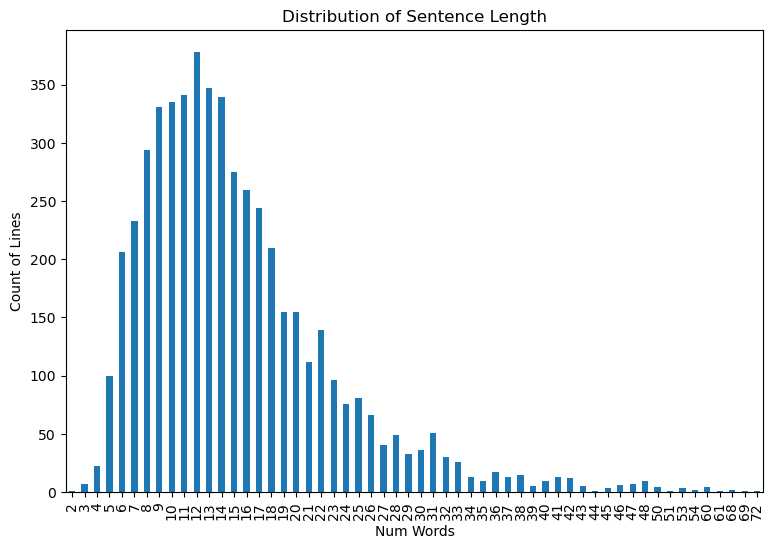

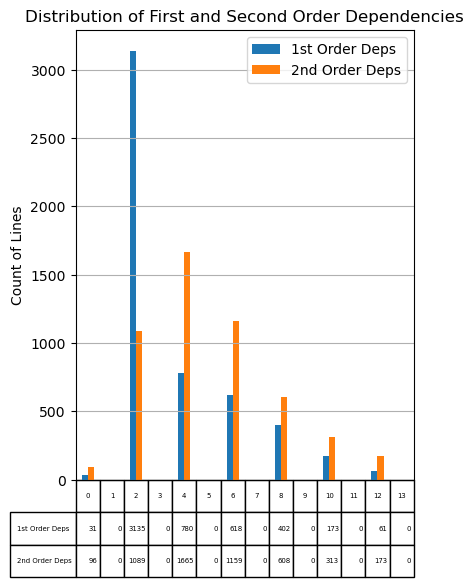

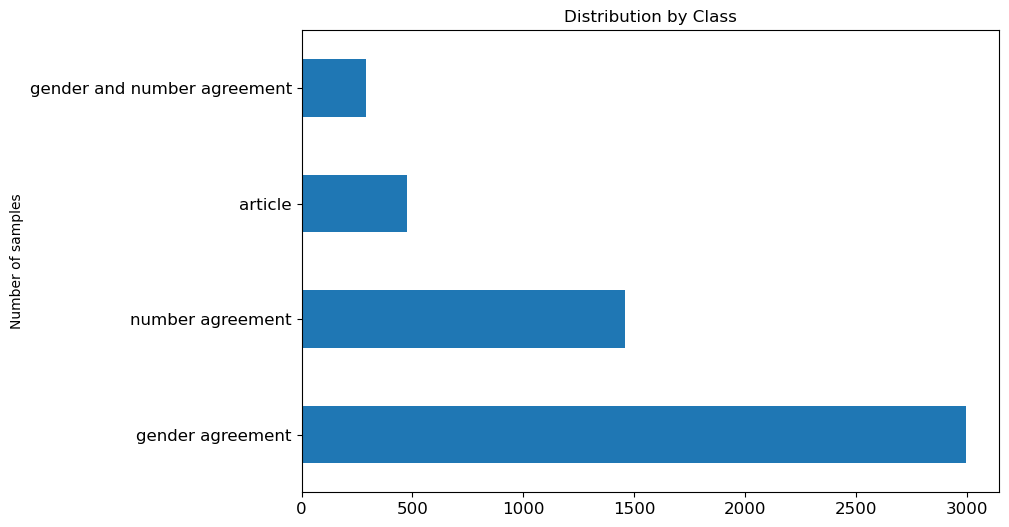

CPU times: user 2.09 s, sys: 895 ms, total: 2.99 s
Wall time: 670 ms


In [40]:
%%time
# Plot the data
def build_df_dependencies(df):
    df_dependencies = pd.DataFrame({'Num Dependencies':list(range(0, 14))})
    df_dependencies['1st Order Deps'] = 0
    df_dependencies['2nd Order Deps'] = 0
    df_first_order =  df['First Order Dependencies'].value_counts().sort_index(axis=0)
    df_second_order =  df['Second Order Dependencies'].value_counts().sort_index(axis=0)
    for num_dependencies, count in df_first_order.items():
        df_dependencies.loc[df_dependencies['Num Dependencies'] == num_dependencies, '1st Order Deps'] = count
    for num_dependencies, count in df_second_order.items():
        df_dependencies.loc[df_dependencies['Num Dependencies'] == num_dependencies, '2nd Order Deps'] = count
    return df_dependencies

def build_dfs(df):
    df_plot = pd.DataFrame()
    df_plot['Sentence Len'] = df.apply(lambda row: len(row.target), axis=1)
    df_plot['Parsing Order Len'] = df.apply(lambda row: len(row.predicted_parsing_order) if row.predicted_parsing_order else 0, axis=1)
    df_plot['First Order Dependencies'] = df.apply(lambda row: count_by_order(row, 2), axis=1)
    df_plot['Second Order Dependencies'] = df.apply(lambda row: count_by_order(row, 3), axis=1)
    return df_plot, build_df_dependencies(df_plot)
    
def plots(df):
    df_plot, df_dependencies = build_dfs(df)
    
    df_plot['Sentence Len'].value_counts().sort_index(axis=0).plot(
        kind='bar',
        fontsize=10,
        figsize=(9, 6),
        xlabel="Num Words",
        ylabel="Count of Lines",
        xticks = None,
        title="Distribution of Sentence Length",
    )
    plt.show()

    plot_combo = df_dependencies.plot(
        kind='bar',
        x='Num Dependencies',
        fontsize=10,
        figsize=(5, 6),
        ylabel='Count of Lines',
        title='Distribution of First and Second Order Dependencies',
        grid=True,
        table=True
    )
    plot_combo.axes.get_xaxis().set_visible(False)
    # Getting the table created by pandas and matplotlib
    table = plot_combo.tables[0]
    # Setting the font size
    table.set_fontsize(10)
    # Rescaling the rows to be more readable
    table.scale(1,2)
    plt.tight_layout()
    plt.show()
    
    df_class_dist = df_errors.error_type.value_counts()
# #     df_class_dist.rename(mapper = {'gender agreement': 'Gender', 'number agreement'}, inplace=True)
# #     gender agreement               2995
# # number agreement               1460
# # article                         477
# # gender and number agreement     291
#     print(df_class_dist.columns)
#     print(df_class_dist)
    
    df_class_dist.plot(
        kind='barh',
        fontsize=12,
        figsize=(9, 6),
        xlabel="Number of samples",
        ylabel="Error Class",
        title="Distribution by Class")
    plt.show()
    
    # plot2 = df_plot['First Order Dependencies'].value_counts().sort_index(axis=0).plot(
    #     kind='bar',
    #     fontsize=8,
    #     figsize=(9, 6),
    #     xlabel='Num First Order Dependencies',
    #     ylabel='Count of Lines',
    #     title='Distribution of First Order Dependencies',
    #     grid=True,
    #     table=True
    # )
    # plot2.axes.get_xaxis().set_visible(False)
    # # Getting the table created by pandas and matplotlib
    # table = plot2.tables[0]
    # # Setting the font size
    # table.set_fontsize(10)
    # # Rescaling the rows to be more readable
    # table.scale(1,2)
    # plt.tight_layout()
    # plt.show()

    # plot3 = df_plot['Second Order Dependencies'].value_counts().sort_index(axis=0).plot(
    #     kind='bar',
    #     fontsize=8,
    #     figsize=(9, 6),
    #     xlabel='Num Second Order Dependencies',
    #     ylabel='Count of Lines',
    #     title='Distribution of Second Order Dependencies',
    #     grid=True,
    #     table=True)
    # plot3.axes.get_xaxis().set_visible(False)
    # # Getting the table created by pandas and matplotlib
    # table = plot3.tables[0]
    # # Setting the font size
    # table.set_fontsize(10)
    # # Rescaling the rows to be more readable
    # table.scale(1,2)
    # plt.tight_layout()
    # plt.show()

plots(df_errors)

In [41]:
# Explore the rows with empty parsing order
# TODO: explore why about 30 rows have empty parsing orders and 38 rows are missing first order dependencies.
print(f'{df_errors[(df_errors.predicted_parsing_order.isna())].shape}')
with pd.option_context('display.max_colwidth', None):
    display(df_errors[df_errors.predicted_parsing_order.isna()])

(31, 23)


,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,predicted_parsing_order_src
211,211,459,775,0c66030cc2c5487d1736df818425e524874d29ada3c571b76adb1731e1015055,SPA 2,"No tiene ""oscars"" pero Leonardo Dicaprio solomente recibió un oscar el año pasado, así que....Pues, quiero ver una película con él este año y quiero conocer Walken también.","No tiene ""oscars"" pero Leonardo Dicaprio solomente recibió un oscar el año pasado, así que....Pues, quiero ver una película con él este año y quiero conocer []{a}<az:do:an> Walken también.",1,[]{a}<az:do:an>,0,...,"[No, tiene, "", oscars, "", pero, Leonardo, Dicaprio, solomente, recibió, un, oscar, el, año, pasado, ,, así, que, ., ., ., ., Pues, ,, quiero, ver, una, película, con, él, este, año, y, quiero, conocer, a, Walken, también, .]","[35, 75]",article,"[No, tiene, "", oscars, "", pero, Leonardo, Dicaprio, solomente, recibió, un, oscar, el, año, pasado, ,, así, que, ., ., ., ., Pues, ,, quiero, ver, una, película, con, él, este, año, y, quiero, conocer, [NONE], Walken, también, .]",article,[],None,A,az:do,None
440,440,18,29,daeec1fa32f04db8a029f6cfe42d541e117b4e7621f61ae9fddbc7b5016766fc,SPA 3,Bill and Ted es de los dos Bill and Ted y els van en diferentes tiempos como los 1800’s o más patras.También van en la futuro.,Bill and Ted es de los dos Bill and Ted y els van en diferentes tiempos como los 1800’s o más patras.También van en [la]{el}<ga:mf:det:inan> futuro.,1,[la]{el}<ga:mf:det:inan>,0,...,"[Bill, and, Ted, es, de, los, dos, Bill, and, Ted, y, els, van, en, diferentes, tiempos, como, los, 1800, ’, s, o, más, patras, ., También, van, en, el, futuro, .]","[28, 60]",gender agreement,"[Bill, and, Ted, es, de, los, dos, Bill, and, Ted, y, els, van, en, diferentes, tiempos, como, los, 1800, ’, s, o, más, patras, ., También, van, en, la, futuro, .]",gender agreement,[],None,A,ga:mf,None
475,475,37,61,77581a46b29c5a9e1e74abbffea7e7a3c03b59fc3457647f571a1ba1ddbacce3,SPA 3,"Todavía me gusta escuchar ""Destiny's Child"" y su música es estupendo.","Todavía me gusta escuchar ""Destiny's Child"" y su música es [estupendo]{estupenda}<ga:fm:adj:inan>.",1,[estupendo]{estupenda}<ga:fm:adj:inan>,0,...,"[Todavía, me, gusta, escuchar, "", Destiny, ', s, Child, "", y, su, música, es, estupenda, .]","[14, 31]",gender agreement,"[Todavía, me, gusta, escuchar, "", Destiny, ', s, Child, "", y, su, música, es, estupendo, .]",gender agreement,[],None,A,ga:fm,None
480,480,40,65,139d6a79730caee9d68ad994e3fb047e5c0b6b31d42450bcf838d3943b5e33dc,SPA 3,Empezó con el grupo se llama Destiny's Child antes de realizar solo.,Empezó con el grupo se llama Destiny's Child antes de realizar [solo]{sola}<ga:fm:adj:an>.,1,[solo]{sola}<ga:fm:adj:an>,0,...,"[Empezó, con, el, grupo, se, llama, Destiny, ', s, Child, antes, de, realizar, sola, .]","[13, 29]",gender agreement,"[Empezó, con, el, grupo, se, llama, Destiny, ', s, Child, antes, de, realizar, solo, .]",gender agreement,[],None,A,ga:fm,None
874,874,201,298,d539be0f37ba2351c41b5ce478dfc7a23b8bb61a7256f29cb0bef8e2e203e25f,SPA 2,Hugh Jackman es un buen actor pero también es un buen cantante y bailarina.,Hugh Jackman es un buen actor pero también es un buen cantante y [bailarina]{bailarín}<ga:mf:noun:an>.,1,[bailarina]{bailarín}<ga:mf:noun:an>,0,...,"[Hugh, Jackman, es, un, buen, actor, pero, tambie, ́, n, es, un, buen, cantante, y, bailarín, .]","[15, 33]",gender agreement,"[Hugh, Jackman, es, un, buen, actor, pero, tambie, ́, n, es, un, buen, cantante, y, bailarina, .]",gender agreement,[],None,A,ga:mf,None
946,946,229,336,52d24c89b5a3209f034532a43e7693abc52d49d3f25a2ae4aeaf0e32de8a6a45,SPA 2,"Me gustan muchos tipos de musica (rap, r&b,pop) , y muchas artistas.","Me gustan muchos tipos de musica (rap, r&b,pop) , y [muchas]{muchos}<ga:mf:det:an> artistas.",1,[muchas]{muchos

In [42]:
df_errors[df_errors.essay_new == 'Me gustan muchos tipos de musica (rap, r&b,pop) , y muchas artistas.']

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,predicted_parsing_order_src
946,946,229,336,52d24c89b5a3209f034532a43e7693abc52d49d3f25a2a...,SPA 2,"Me gustan muchos tipos de musica (rap, r&b,pop...","Me gustan muchos tipos de musica (rap, r&b,pop...",1,[muchas]{muchos}<ga:mf:det:an>,0,...,"[Me, gustan, muchos, tipos, de, musica, (, rap...","[17, 38]",gender agreement,"[Me, gustan, muchos, tipos, de, musica, (, rap...",gender agreement,[],None,A,ga:mf,None


In [43]:
dep_parsing_tree(NLP_ES, 'Puedes visitar a sus amigos.', df_errors.iloc[363].correction_index, verbosity=2)


# COWSL2H_parsing_order(NLP_ES, df_errors, 363)

id -> head: {0: 1, 1: 1, 2: 4, 3: 4, 4: 1}
head -> ids: {1: [0, 1, 4], 4: [2, 3]}


{'1': 3, '2': 1, '3': 3, '4': 2}

In [44]:
ids_to_check = [946, 4833]
# print(df_errors.iloc[id_to_check])
# print(type(df_errors.iloc[id_to_check].source))
# print(type(df_errors.iloc[id_to_check].source))
# print(type(df_errors.iloc[id_to_check].essay_new))
for idx in ids_to_check:
    COWSL2H_parsing_order(NLP_ES, df_errors, idx)
# parsing_order = dep_parsing_tree(NLP_ES, df_errors.iloc[id_to_check].essay_new, eval(df_errors.iloc[id_to_check].correction_index), verbosity=2)


id -> head: {0: 1, 1: 1, 2: 3, 3: 1, 4: 5, 5: 3, 7: 3, 9: 7, 11: 7, 14: 16, 15: 16, 16: 1}
head -> ids: {1: [0, 1, 3, 16], 3: [2, 5, 7], 5: [4], 7: [9, 11], 16: [14, 15]}


-----------------------------------------------

Orig: Me gustan muchos tipos de musica ( rap , r & b , pop ) , y muchas artistas .
Corr: Me gustan muchos tipos de musica (rap, r&b,pop) , y muchas artistas.
row.source: ['Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchas', 'artistas', '.']
row.target: ['Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchos', 'artistas', '.']
Concatenated: ['Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchas', 'artistas', '.', 'SEP', 'Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchos', 'artistas', '.']

Correction index: [17, 38]

Corrected offset: 21

computed pred_parse_order: {}
id -> head: {0: 2, 1: 2, 2: 4, 4: 4, 5: 6, 6: 4, 7: 10, 8: 10, 9: 10, 10: 4, 11: 10, 12: 11}
head -> ids: {2: [0, 1]

-----------------------------------------------

Orig: Para este vacaciones , quiero my novio y mis mejores amigas ir conmigo .
Corr: Para este vacacion, quiero my novio y mi mejor amigas ir conmigo.
row.source: ['Para', 'este', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.']
row.target: ['Para', 'esta', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.']
Concatenated: ['Para', 'este', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.', 'SEP', 'Para', 'esta', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.']

Correction index: [1, 16]

Corrected offset: 15

computed pred_parse_order: {'0': 3, '1': 1, '2': 2, '4': 3}


In [45]:
df_errors.sample(2)

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,predicted_parsing_order_src
5200,5200,40,1284,079db1629d32e737f36b0bcc6991a7400f92d9a333f163...,SPA 1,¡Me gustaría hacer este vacación!,¡Me gustaría hacer [este]{esta}<ga:fm:det:inan...,2,[este]{esta}<ga:fm:det:inan>,0,...,"[¡, Me, gustaría, hacer, esta, vacaciones, !]","[4, 12]",gender agreement,"[¡, Me, gustaría, hacer, este, vacaciones, !]",gender agreement,[],"{'3': 3, '4': 1, '5': 2, '11': 3, '12': 1, '13...",A,ga:fm,"{'3': 3, '4': 1, '5': 2}"
1414,1414,416,696,1b07760b7fc83f51843082bc6c7958d9674a08a9b79520...,SPA 2,Su primero canción fue “Royal”.,Su [primero]{primera}<ga:fm:det:inan> canción ...,1,[primero]{primera}<ga:fm:det:inan>,0,...,"[Su, primera, canción, fue, “, Royal, ”, .]","[1, 10]",gender agreement,"[Su, primero, canción, fue, “, Royal, ”, .]",gender agreement,[],"{'0': 3, '1': 1, '2': 2, '4': 3, '9': 3, '10':...",A,ga:fm,"{'0': 3, '1': 1, '2': 2, '4': 3}"


## To JSON representation of each row

In [46]:
def to_json_df(in_df):
    df_proj = in_df[in_df.predicted_parsing_order.notnull()][['target', 'source', 'evidence_index', 'correction_index', 'error_type', 'predicted_parsing_order', 'origin']]    
    df_proj = df_proj.dropna()
    print(f'Selected {df_proj.shape[0]} non-null rows from {in_df.shape[0]} rows. {in_df.shape[0] - df_proj.shape[0]} rows dropped.')
    df_json = df_proj.copy(deep=True)
    df_json['json'] = df_proj.apply(lambda x: x.to_json(), axis=1)
    return df_json[['json']]


In [47]:
def export_as_json(df, train_file, test_file, dev_file):
    def write_out(df, filename):
        with open(f'{args.PROCESSED_DATA_FOLDER}/{filename}', "w+") as file1:
            for i, row in df.iterrows():
                file1.write(f'{json.dumps(eval(row.json))}\n')

    json_df = to_json_df(df)
    from sklearn.model_selection import train_test_split

    train_df, test_dev_df = train_test_split(json_df, test_size=0.2)
    test_df, dev_df = train_test_split(test_dev_df, test_size=0.5)
    # tt.to_csv(args.PROCESSED_DATA_FOLDER + "/rows_as_json.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar=" ")
    write_out(train_df, train_file)
    write_out(test_df, test_file)
    write_out(dev_df, dev_file)

# Export after remove lines with empty predicted parsing order until the underlying data is fixed.
export_as_json(df_errors, args.full_dataset.GEC_TRAIN_CSV, args.full_dataset.GEC_TEST_CSV, args.full_dataset.GEC_DEV_CSV)

Selected 5192 non-null rows from 5223 rows. 31 rows dropped.


## Convert to NER Format

In [48]:
# Helper methods to convert to NER format
def idx2vec(idx, length):
    if isinstance(idx, list):
        if len(idx) != 0:
            idx_vec = [1 if i in idx else 0 for i in range(length)]
        else:
            idx_vec = [0] * length
    elif isinstance(idx, dict):
        idx_vec = [0] * length
        for k, v in idx.items():
            if int(k) < len(idx_vec):
                idx_vec[int(k)] = v
    return idx_vec

def to_ner(csv_filename, pkl_filename):
    sep_token = ['[MOD]']
    data = []
    
    with open(f'{args.PROCESSED_DATA_FOLDER}/{csv_filename}', 'r') as f:
        for line in f:
            data.append(json.loads(line))    
    
    # convert into ner data structure
    def sent_to_ner_data(sentence, evidence_index, correction_index, error_type, parsing_order, ids=0, prefix=True):
        sent_data = []
        for j, token in enumerate(sentence):
            new_tokens = token
            if evidence_index:  # for dev and train data
                if evidence_index[j]:
                    type = classes_ids[error_type]
                    if prefix:
                        if j == 0 or evidence_index[j - 1] == 0:
                            cls = 'B-' + type
                        else:
                            cls = 'I-' + type
                    else:
                        cls = type
                else:
                    cls = 'O'
                sent_data.append([
                    ids,
                    new_tokens,
                    cls,
                    classes_ids[error_type],
                    correction_index[j],
                    parsing_order[j]
                ])
        return sent_data

    new_data = []
    for i, d in tqdm(enumerate(data)):
        sentence = d['target'] + sep_token + d['source']
        correction_index = idx2vec(d['correction_index'], len(sentence))
        evidence_index = idx2vec(d['evidence_index'], len(sentence))
        predicted_parsing_order = idx2vec(d['predicted_parsing_order'], len(sentence))
        ner_d = sent_to_ner_data(sentence, evidence_index, correction_index, d['error_type'], predicted_parsing_order, ids=i)
        new_data.extend(ner_d)

    with open(f'{args.PROCESSED_DATA_FOLDER}/{pkl_filename}', 'wb') as f:
        pickle.dump(new_data, f)
    pd.DataFrame(new_data).to_csv(f'{args.PROCESSED_DATA_FOLDER}/tt.csv', index=False)

    

In [49]:
# Convert training dataset to NER
to_ner(args.full_dataset.GEC_TRAIN_CSV, args.full_dataset.GEC_TRAIN_NER)

# Convert test dataset to NER
to_ner(args.full_dataset.GEC_TEST_CSV, args.full_dataset.GEC_TEST_NER)

# Convert dev dataset to NER
to_ner(args.full_dataset.GEC_DEV_CSV, args.full_dataset.GEC_DEV_NER)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Create Small Handcrafted Dataset For Troubleshooting Training

In [103]:
# Sample 100 rows with 5 to 15 words
def sampled(df, min_len, max_len, num_per_class):
    df_filtered = df[(df.target.map(len) > min_len) & (df.target.map(len) < max_len)]
    classes = df_filtered.error_type.unique()
    df_selected = pd.concat([df_filtered[df_filtered.error_type == cur].sample(num_per_class) for cur in classes])    
    return df_selected

def create_small_dataset(df):
    df_small = sampled(df_errors, 5, 10, 25)
    # df_small.evidence_index = df_small.apply(evidence_index_for, axis=1)
    df_smaller = df_small #.sample(1)
    # df_smaller.evidence_index = df_smaller.apply(evidence_index_for, axis=1)
    return df_smaller
    # return df_small.sample(2).apply(evidence_index_for, axis=1)
    # .to_csv(f'{args.PROCESSED_DATA_FOLDER}/bert_small.csv', index=False)
    
df_errors_smaller = create_small_dataset(df_errors)

# Manually add evidence words
# Convert to JSON
# Create train-dev-test split
# Create NER output

In [116]:
def evidence_index_for(row, force_overwrite):
    print(f'-------------------{row.orig_index}-------------------')
    if len(row.evidence_index) > 0 and not force_overwrite:
        # Already processed
        print(f'-------------------using existing-------------------')
        return row.evidence_index
    print(f'Error Type: {row.error_type}')
    print(f'Correction: {row.correction_index}')
    print(f'X: {row.source}')
    print(f'Y: {row.target}')    
    user_opt = None
    msg = f'Enter evidence indices (csv with each value between {0} and {len(row.source) - 1} ) or -1 to quit'
    quit = False
    evidence_indices = []
    try:
        user_input = input(f'{msg}: ')
        if user_input == '-1':
            quit = True
        evidence_indices = eval(user_input)
        print(f'Evidence indices: {evidence_indices}')
    except ValueError:
        print(msg)
        user_opt = None

    print(f'------------------------------------------------------')
    if quit:
        return []
    else:
        return evidence_indices
    
def update_evidence_index(df, force_overwrite=False, num_rows=10):
    count = 0
    for i, row in df.iterrows():
        if count >= num_rows:
            break
        if len(row.evidence_index) == 0 or force_overwrite:
            df.at[i,'evidence_index'] = evidence_index_for(row, force_overwrite)
            count = count + 1
        # else:
        #     print(f'-------------------{row.orig_index}-------------------')
        #     # Already processed
        #     print(f'-------------------using existing-------------------')

In [134]:
update_evidence_index(df_errors_smaller, num_rows=10)

-------------------2124-------------------
Error Type: gender and number agreement
Correction: [4, 12]
X: ['Mis', 'vacaciones', 'perfectas', 'incluye', 'mucho', 'actividades', '.']
Y: ['Mis', 'vacaciones', 'perfectas', 'incluye', 'muchas', 'actividades', '.']


Enter evidence indices (csv with each value between 0 and 6 ) or -1 to quit:  [5]


Evidence indices: [5]
------------------------------------------------------
-------------------1390-------------------
Error Type: gender and number agreement
Correction: [4, 11]
X: ['Taylor', 'tiene', 'muchos', 'amigos', 'famosa', '.']
Y: ['Taylor', 'tiene', 'muchos', 'amigos', 'famosos', '.']


Enter evidence indices (csv with each value between 0 and 5 ) or -1 to quit:  [3]


Evidence indices: [3]
------------------------------------------------------
-------------------4931-------------------
Error Type: gender and number agreement
Correction: [0, 8]
X: ['Un', 'vacaciones', 'perfectas', 'estaría', 'en', 'Ireland', '.']
Y: ['unas', 'vacaciones', 'perfectas', 'estaría', 'en', 'Ireland', '.']


Enter evidence indices (csv with each value between 0 and 6 ) or -1 to quit:  [0]


Evidence indices: [0]
------------------------------------------------------
-------------------3184-------------------
Error Type: gender and number agreement
Correction: [2, 12]
X: ['Ellos', 'tienen', 'mucho', 'activitidads', 'en', 'el', 'programa', 'television', '.']
Y: ['Ellos', 'tienen', 'muchas', 'activitidads', 'en', 'el', 'programa', 'television', '.']


Enter evidence indices (csv with each value between 0 and 8 ) or -1 to quit:  [3]


Evidence indices: [3]
------------------------------------------------------


In [135]:
df_errors_smaller[df_errors_smaller.evidence_index.map(len) > 0].shape

(100, 23)

In [137]:
df_errors_smaller.to_csv(f'{args.PROCESSED_DATA_FOLDER}/bert_small.csv', index=False)

In [141]:
# Reload the smaller dataset
def load_smaller():
    # Converters not working
    df = pd.read_csv(args.PROCESSED_DATA_FOLDER + "/bert_small.csv", index_col=None, header=0)
    # The source, target and correction_index cols are loaded as string version of lists. Convert them to actual lists.
    df.source = df.apply(lambda row: eval(row.source), axis=1)
    df.target = df.apply(lambda row: eval(row.target), axis=1)
    df.correction_index = df.apply(lambda row: eval(row.correction_index), axis=1)
    df.evidence_index = df.apply(lambda row: eval(row.evidence_index), axis=1)
    df.predicted_parsing_order = df.apply(lambda row: eval(row.predicted_parsing_order), axis=1)
    return df

df_errors_smaller = load_smaller()
df_errors_smaller

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,predicted_parsing_order_src
0,329,740,1221,8820ece7c6e0a9e983c86f78b980cc5721cbb1d4057a2d...,SPA 2,Voy a ver un montón de gente.,Voy a ver []{a}<az:do:an> un montón de gente.,1,[]{a}<az:do:an>,0,...,"[Voy, a, ver, a, un, montón, de, gente, .]","[3, 13]",article,"[Voy, a, ver, [NONE], un, montón, de, gente, .]",article,"[2, 4]","{'2': 3, '3': 1, '4': 2, '6': 3, '12': 3, '13'...",A,az:do,"{'2': 3, '3': 1, '4': 2, '6': 3}"
1,363,886,1513,16b307a5700ff3479d1c25941dbef9e75c72b0739c88e9...,SPA 2,Puedes visitar sus amigos.,Puedes visitar []{a}<az:do:an> sus amigos.,1,[]{a}<az:do:an>,0,...,"[Puedes, visitar, a, sus, amigos, .]","[2, 9]",article,"[Puedes, visitar, [NONE], sus, amigos, .]",article,"[1, 3]","{'1': 3, '2': 1, '3': 2, '8': 3, '9': 1, '10': 2}",A,az:do,"{'1': 3, '2': 1, '3': 2}"
2,58,129,209,44c7f1bc0333e4d6c1bf85aa10565e6bded340213da5e5...,SPA 3,Quiero ir a visitar Messi.,Quiero ir a visitar []{a}<az:do:an> Messi.,1,[]{a}<az:do:an>,0,...,"[Quiero, ir, a, visitar, a, Messi, .]","[4, 12]",article,"[Quiero, ir, a, visitar, [NONE], Messi, .]",article,"[3, 5]","{'0': 3, '1': 3, '2': 3, '3': 2, '4': 1, '8': ...",A,az:do,"{'0': 3, '1': 3, '2': 3, '3': 2, '4': 1}"
3,153,338,512,bf2861dfac9781c0c68d7a2b26213b669c18302708d13f...,SPA 1,Él enseñar ellos jugar baloncesto.,Él enseñar []{a}<az:do:an> ellos jugar balonc...,1,[]{a}<az:do:an>,0,...,"[Él, enseñar, a, ellos, jugar, baloncesto, .]","[2, 10]",article,"[Él, enseñar, [NONE], ellos, jugar, baloncesto...",article,"[1, 3]","{'0': 3, '1': 2, '2': 1, '3': 3, '8': 3, '9': ...",A,az:do,"{'0': 3, '1': 2, '2': 1, '3': 3}"
4,309,701,1178,f746419b70c3b8b78e5d99013182b5115c1fb67aeb4671...,SPA 3,Nosotros visitaríamos mi novia's familia.,Nosotros visitaríamos []{a}<az:do:an> mi novia...,1,[]{a}<az:do:an>,0,...,"[Nosotros, visitaríamos, a, mi, novia, ', s, f...","[2, 12]",article,"[Nosotros, visitaríamos, [NONE], mi, novia, ',...",article,"[1, 3]","{'1': 3, '2': 1, '3': 2, '11': 3, '12': 1, '13...",A,az:do,"{'1': 3, '2': 1, '3': 2}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4544,745,1228,fb83ca0ced7ca4868a9e1cd1d35652a54e804992f51fbd...,SPA 2,Mi perfecto vacaciones es viajando el mundo.,[Mi]{mis}<na:ps:det:inan> [perfecto]{perfectas...,2,[perfecto]{perfectas}<ga:na:fm:ps:adj:inan>,1,...,"[mis, perfectas, vacaciones, es, viajando, el,...","[1, 10]",gender and number agreement,"[mis, perfecto, vacaciones, es, viajando, el, ...",gender and number agreement,[2],"{'0': 3, '1': 1, '2': 2, '3': 3, '9': 3, '10':...",A,ga:na:fm:ps,"{'0': 3, '1': 1, '2': 2, '3': 3}"
96,2124,711,1190,c63b1a1c7191239b4942145a301d72ca6146e8217c3ae4...,SPA 1,Mis vacaciones perfectas incluye mucho activid...,Mis vacaciones perfectas incluye [mucho]{mucha...,1,[mucho]{muchas}<ga:na:fm:ps:det:inan>,0,...,"[Mis, vacaciones, perfectas, incluye, muchas, ...","[4, 12]",gender and number agreement,"[Mis, vacaciones, perfectas, incluye, mucho, a...",gender and number agreement,[5],"{'3': 3, '4': 1, '5': 2, '11': 3, '12': 1, '13...",A,ga:na:fm:ps,"{'3': 3, '4': 1, '5': 2}"
97,1390,407,678,8edf67e9c52859d13cfff0894b9c367c3489fc25a838d9...,SPA 3,Taylor tiene muchos amigos famosa.,Taylor tiene muchos amigos [famosa]{famosos}<g...,1,[famosa]{famosos}<ga:na:mf:ps:adj:an>,0,...,"[Taylor, tiene, muchos, amigos, famosos, .]","[4, 11]",gender and number agreement,"[Taylor, tiene, muchos, amigos, famosa, .]",gender and number agreement,[3],"{'1': 3, '2': 3, '3': 2, '4': 1, '8': 3, '9': ...",A,ga:na:mf:ps,"{'1': 3, '2': 3, '3': 2, '4': 1}"
98,4931,937,1595,45cb772775467cfd443567ac1ce70d8e8e755a0a23c248...,SPA 3,Un vacaciones perfecto estaría en Ireland.,[Un]{unas}<ga:na:fm:ps:det:inan> vacaciones [p...,2,[Un]{unas}<ga:na:fm:ps:det:inan>,0,...,"[unas, vaca

In [146]:
export_as_json(df_errors_smaller, args.small_dataset.GEC_TRAIN_CSV, args.small_dataset.GEC_TEST_CSV, args.small_dataset.GEC_DEV_CSV)

Selected 100 non-null rows from 100 rows. 0 rows dropped.


In [147]:
# Convert training dataset to NER
to_ner(args.small_dataset.GEC_TRAIN_CSV, args.small_dataset.GEC_TRAIN_NER)

# Convert test dataset to NER
to_ner(args.small_dataset.GEC_TEST_CSV, args.small_dataset.GEC_TEST_NER)

# Convert dev dataset to NER
to_ner(args.small_dataset.GEC_DEV_CSV, args.small_dataset.GEC_DEV_NER)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]